# CNN   small datasets 학습


- 학습 Data양이 많지 않을 때 CNN을 통한 모델 학습이 어려울 수 있다.
    - CNN모델 뿐 아니라 딥러닝 모델은 대량의 데이터셋을 학습해야 좋은 성능을 낼 수 있다.
- 학습 시킬 Data 양이 많지 않아 딥러닝 모델의 학습에 어려움이 있을 때 다음과 같은 방법을 이용해 모델 성능을 높일 수있다.
    - **Data augmentation 활용**
        - Image에 다양한 효과를 주어 그럴듯한 변형 데이터들을 생성해서 데이터양을 늘린다.
            - Train dataset은 전체 대상 이미지들을 샘플링한 것이기 때문에 모든 형태를 다 가지고 있지 않다. Data augmentation은 train set의 이미지에 다양한 효과를 주어 실제 데이터셋과의 간격을 줄인다.
            - 영상데이터의 경우 각 영상 데이터의 색변경, 이미지잘라내기, 회전시키기, 명암변경 등을 적용하여 이미지들을 추가로 만들어 data의 수를 늘린다.
        - **모델의 Overfitting을 개선시킨다.**
        - pytorch image augmentation을 위한 클래스들
            - https://pytorch.org/vision/stable/transforms.html
            - https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
    - **Pre-trained network**의 활용한 **Transfer learning (전이학습)**
        - 매우 큰 데이터셋으로 미리 Training한 모델을 이용해 모델을 정의한다.
        - 성능이 좋은모델을 다량의 데이터로 학습시킨 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

# Image Augmentation 예제

In [1]:
import torch
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt

In [2]:
# 이미지 출력 함수
def image_show(img_path, transforms):
    """
    이미지 경로와 transforms를 받아서 적용한뒤 원본이미지와 처리된 이미지를 출력한다.
    transforms는 8번 적용시켜 출력한다.
    [parameter]
        img_path: str - transforms를 적용할 이미지 경로
        transforms: Transforms 객체. 단 ToTensor()가 첫번째 transforms로 정의되 있어야 한다.
    """
    # 이미지 읽은 뒤 BGR에서 RGB로 변환.
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.rcParams['font.family'] = 'gulim'

    plt.figure(figsize=(15, 12))
    plt.subplot(3, 3, 1)
    plt.imshow(img)
    plt.title('원본')

    for i in range(2, 10):
        result_img = transforms (img)
        plt.subplot(3, 3, i)    
        plt.imshow(result_img.permute(1, 2, 0)) # tensor.permute(1, 2, 0) # axis의 위치를 변경.
        # (ch, h, w) -> (h, w, ch)  -> channel 축(차원)을 맨 뒤로 이동.

    plt.tight_layout()
    plt.show()

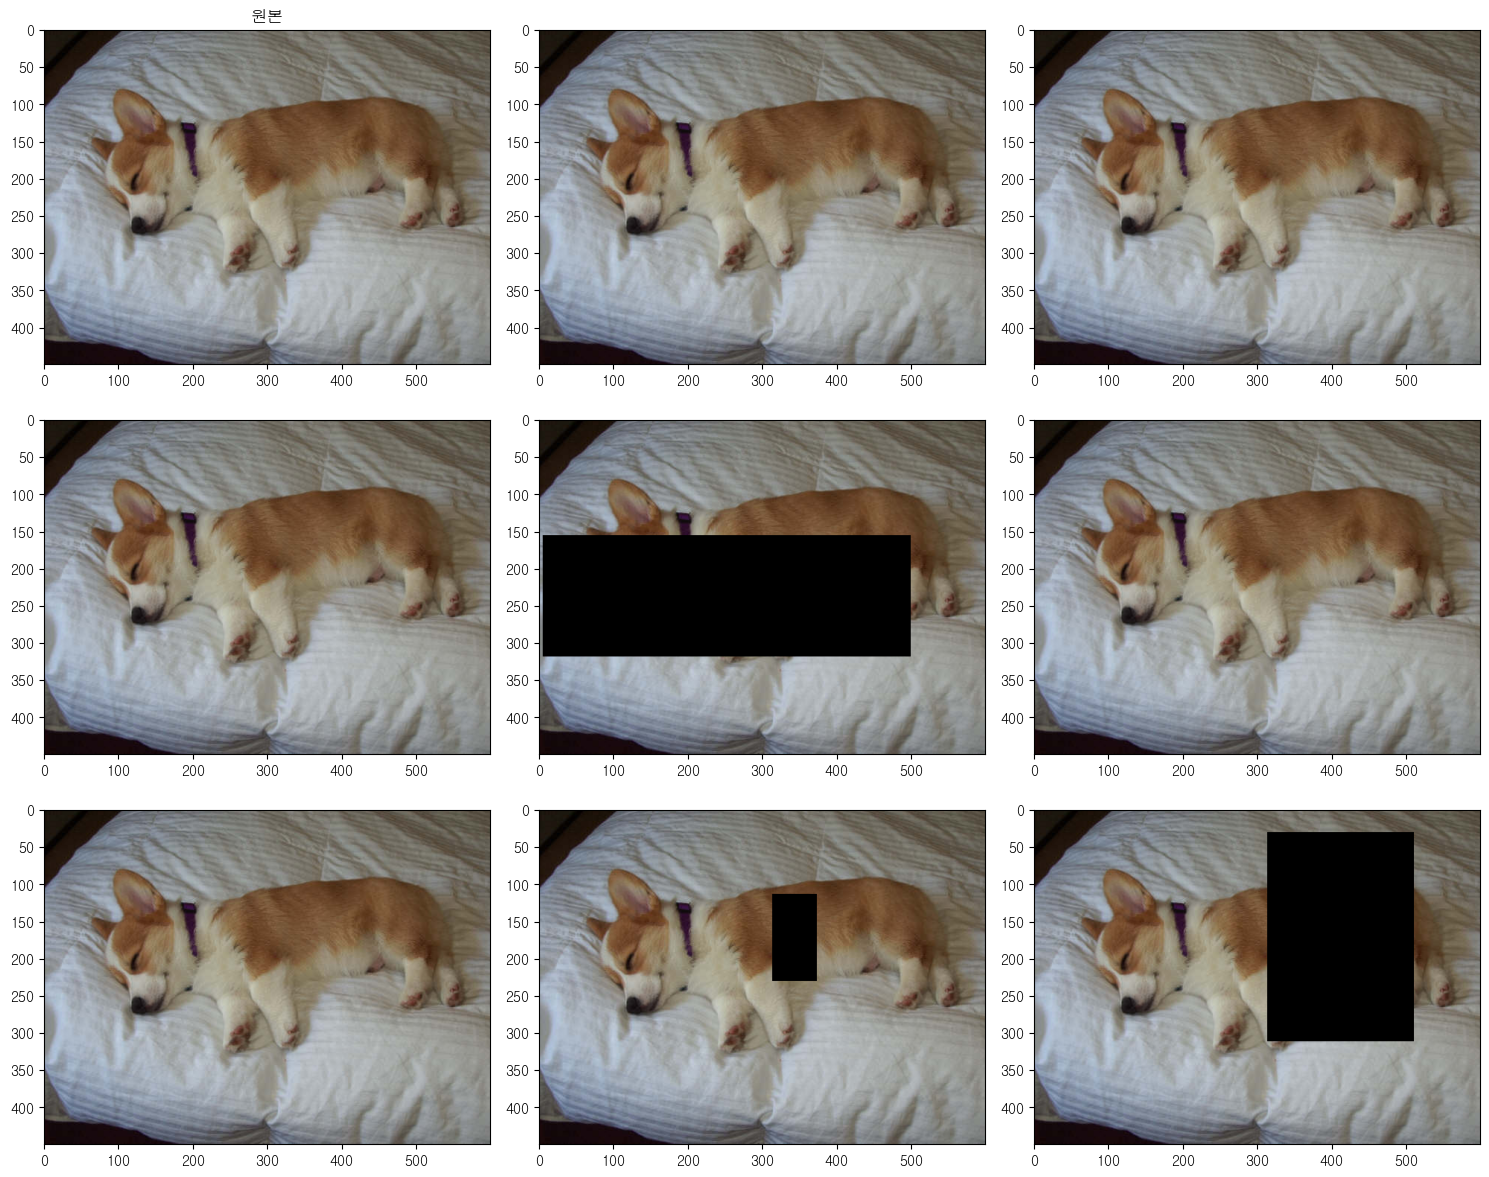

In [26]:

# transforms.Compose([ transforms 들을 묶어서 전달. ])  -> 여러 변환기들을 묶어주는 역할.
transform = transforms.Compose([
    #여러 transforms 들을 묶을 때 가장 먼저 ToTensor() 를 등록한다. (ndarray,PIL.Image를 torch.Tensor로 변환작업이 우선되야함.)
    transforms.ToTensor() 
    ###########################
    # 좌우/상하 반전.  => p=반전이 일어날 확률
    ###########################
    # , transforms.RandomHorizontalFlip(p=0.5) # 좌우
    # , transforms.RandomVerticalFlip(p=0.5)  # 상하
    
    ###########################
    # 회전 - degrees: 회전 각도.  -degrees ~ +degrees 이 범위 안에서 회전.
    #      음수/양수: 시계반대방향, 시계방향.
    ###########################
    # , transforms.RandomRotation(degrees=180)
    
    ###########################
    # affine 이동 변환들
    #  회전, 이동, 전단 변환 처리
    ###########################
    # , transforms.RandomAffine(
    #                           degrees=(0,0),  # 회전 범위 
    #                           translate=(0.1,0.3), # 이동변환(좌우이동범위, 상하 이동범위): 실수-이미지 대비 비율, 정수: pixcel로 지정. (0.1, 0.3): 좌우: -0.1 ~ 0.1, 상하: -0.3 ~ 0.3                           
    #                           shear=(0.8, 1.2),    #  전단변환. (x축, y축)
    #                           scale=(0.5,1.2),      # 변환후 image의 size를 변경. (전체 이미지 크기가아니라. 이동한 대상의 크기.)  1: 원본사이즈 1미만은 작게, 1초과 크게              
    #                          )
    
    ###########################
    # 가우시안 블러
    # kernel_size: 필터 크기(h, w) - 클수록 blur효과가 커진다.
    # sigma: 표준편차. 클수록 blur효과가 커진다. (실수-고정. tuple-범위=>랜덤화.)
    ###########################
    # , transforms.GaussianBlur(kernel_size=(17,17), sigma=(1, 5))
    
    ########################### 
    # 선명도 (Sharpen)
    # sharpness_factor: 1-원본과동일, 1미만: blur, 1초과: 선명도를 높인다.
    # p: 적용될 확률 (0 ~ 1)
    ###########################
    # , transforms.RandomAdjustSharpness(sharpness_factor=5, p=0.5) 
    
    ###########################
    # 색관련 변환
    #  밝기, 대비, 채도, 색 변환 처리  (시작, 끝) 랜덤값의 범위: 시작 ~ 끝
    ###########################
    # , transforms.ColorJitter(
    #                        brightness=(0.5, 1.7), # 밝기조절
    #                        contrast=(0.8, 1.2),    # 대비조절
    #                        saturation=(0.5, 1.5),  # 채도조절
    #                        hue=(-0.2, 0.2)         # 색변환 (-0.5, 0.5) 사이 실수로 범위를 지정.
    # )
    
    #########################
    # Grayscale - grayscale로 바뀌어도 channel은 3
    #########################
    # , transforms.RandomGrayscale(p=0.5)  # 바뀔 확률 
    
    ############################
    # 픽셀값을 반전 - 확률 지정할 수 있다.  255 -> 0, 0 - 255
    ############################
    # , transforms.RandomInvert(p=0.7)
    
    
    ###########################
    # Center 영역 Crop - 영상의 중앙부분만 짤라낸다. 
    ###########################
    # , transforms.CenterCrop(150) # 잘라낼 크기. (h, w), h와w 같으면 정수.
    # , transforms.Resize(size=(300,300))
    ############################
    # RandomCrop - Crop 영역을 random하게 선택한다.
    ############################
    # , transforms.RandomCrop(150) # crop 할 크기

    ###########################
    # RandomResizedCrop - Random한 영역을 Crop후 지정한 종횡비 resize 한다.
    # ratio: 종횡비(가로/세로 길이의 비율) 
    #    1 : 가로세로가 같은 길이.   
    #    2 : 0.x - 가로 비율이 세로보다 길다. 0.5 -> 가로: 1.5, 세로: 0.5 (원래 길이 대비 늘리고 줄인다.)
    #    3 : 1.x - 세로 비율이 가로보다 길다. 1.5 -> 가로: 0.5, 세로: 1.5
    ###########################
    # , transforms.RandomResizedCrop(
    #                                180,                 # resize 크기
    #                                scale=(0.3, 0.7),   # crop 크기. (이미지 대비 0.3 ~ 0.7 를 crop)
    #                                ratio=(0.5, 1.5)    # 종횡비. 0.5 ~ 1.5
    #                               )
    ##############################
    # 이미지를 부분적으로 삭제한다. (픽셀값을 0으로 변경)
    # p=확률, scale=() 삭제 크기범위, ratio=() 삭제 종횡비 범위 => 지정된 튜플 비율에서 random 하게 선택되 변경됨
    # occlusion(폐색-가려지는 문제)문제에서의 한계를 해결. https://deepapple.tistory.com/8
    ###############################
    , transforms.RandomErasing()

])

img_path = 'test_img/image.jpg'
image_show(img_path, transform)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


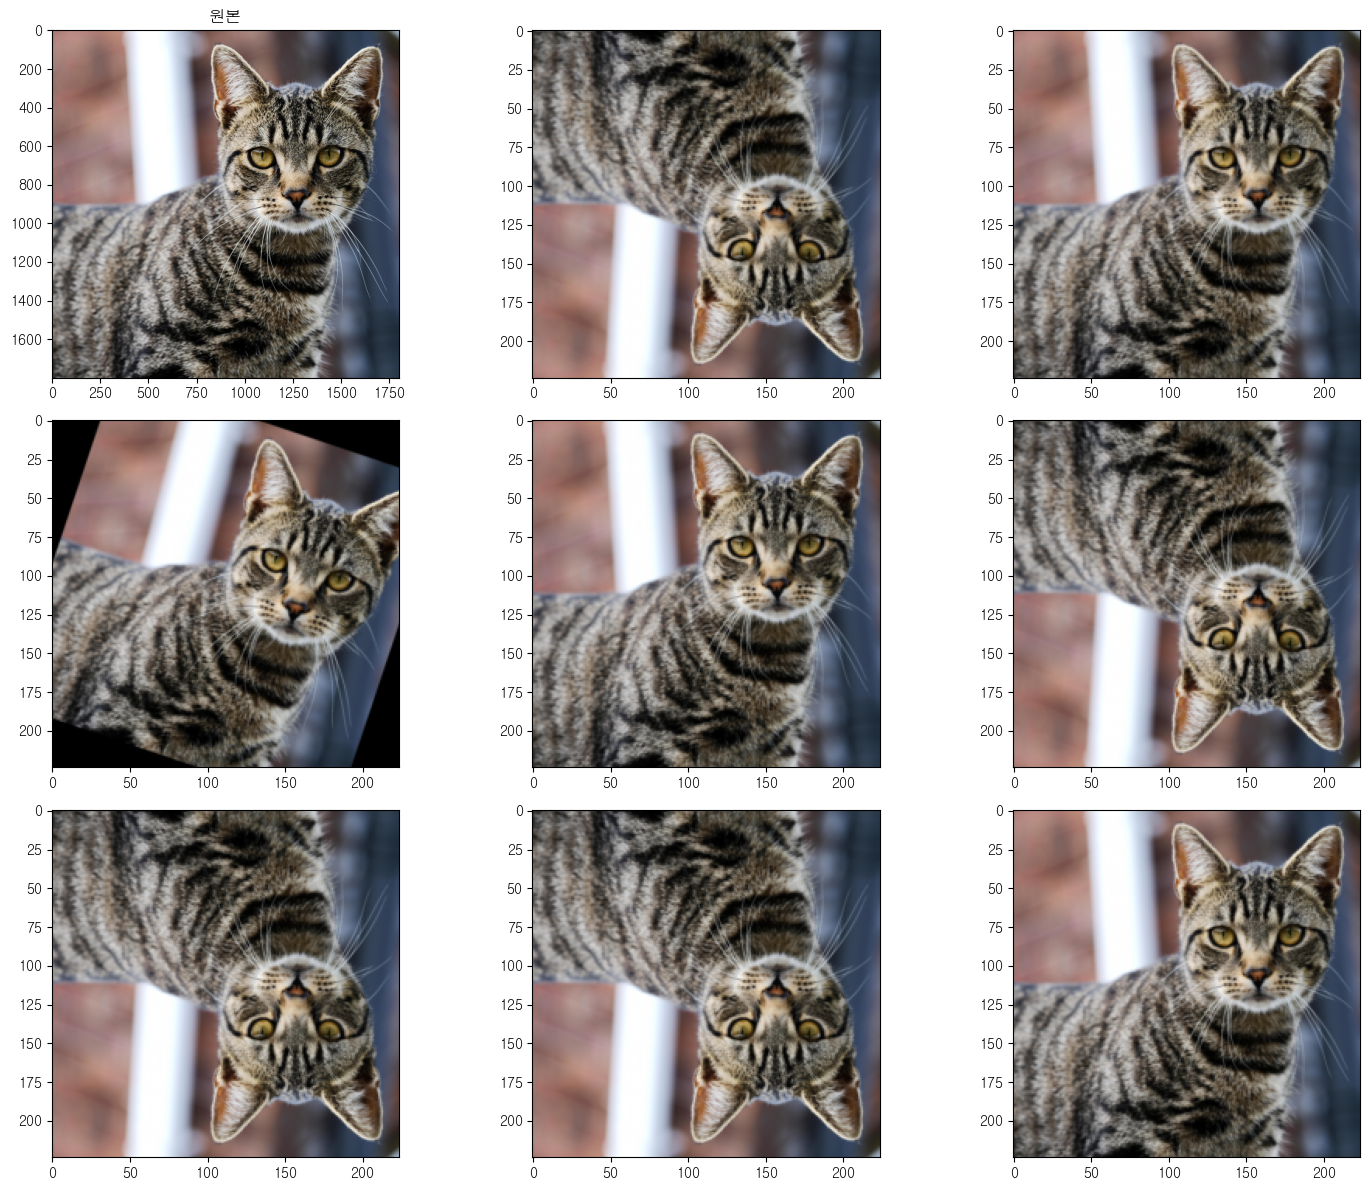

In [29]:

#####################################
# RandomApply() - 여러개 중 Random하게 여러개를 선택해서 적용한다. 선택 확률을 선택할 수 있다.
# RandomChoice() - 여러개 중 하나를 적용한다.
#####################################
# transform2 = transforms.Compose([
#     transforms.ToTensor()
#     , transforms.RandomApply([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(45), 
#         transforms.RandomCrop((200,200)),
#     ], p = 0.3)
#     , transforms.Resize((224, 224), antialias=True)
# ])

transform2 = transforms.Compose([
    transforms.ToTensor()
    , transforms.RandomChoice([
        transforms.RandomRotation(45), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])
    , transforms.Resize((224, 224), antialias=True)
])

image_show('test_img/cat.jpg', transform2)